In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use("ggplot")

pd.set_option('display.max_columns', None)

Missing colon in file '/Users/christianelorenz/.matplotlib/matplotlibrc', line 1 ('cat ~/.matplotlib/matplotlibrc')


Read in the full dataset:

In [2]:
df=pd.read_csv("../../trainset_full.csv", low_memory=False)

Define new feature "Error" that indicates if there is any error. This is the target variable which we would like to predict. Define which features are used.

In [3]:
df["Error"]=df.error_category != "NO_ERROR"
X_train=df[['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id']]
y_train=df.Error
y_train_full=df.error_category

In [29]:
import datetime as dt
X_train["measured_at"]=pd.to_datetime(X_train.measured_at) 
X_train["month"]=X_train.measured_at.dt.month
X_train["bimonth"]=X_train.month // 2 
X_train["bimonthpark"]= str(X_train.bimonth)+":"+str(X_train.park_id)
X_train["Error"]=df.Error

df["measured_at"]=pd.to_datetime(df.measured_at) 
df["month"]=df.measured_at.dt.month
df["bimonth"]=df.month// 2 
df["bimonthpark"]= str(X_train.bimonth)+":"+str(X_train.park_id)

We check once again the features of our model:

In [5]:
X_train.columns

Index(['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'month', 'bimonth',
       'bimonthpark', 'Error'],
      dtype='object')

In the data exploration we have seen that the features rotor_speed and generator_speed are highly correlated with each other, as well as nacelle_direction and wind_direction. Therefore we can merge these four features into two features. 

In [32]:
X_train["speed"]=(X_train.rotor_speed+X_train.generator_speed)/2
X_train["direction"]=(X_train.nacelle_direction+X_train.wind_direction)/2
X_train["isnoon"]=(X_train.hourofday >= 7) & (X_train.hourofday<=14)
X_train["week"]=np.int64(X_train.measured_at.dt.isocalendar().week)

df["speed"]=(df.rotor_speed+df.generator_speed)/2
df["direction"]=(df.nacelle_direction+df.wind_direction)/2
df["hourofday"]=df.measured_at.dt.hour
df["isnight"]=(df.hourofday >= 18) | (df.hourofday <=5)
df["isnoon"]=(df.hourofday >= 7) & (df.hourofday<=14)
df["week"]=np.int64(df.measured_at.dt.isocalendar().week)

In [33]:
num_attribs=['speed', 'power',
       'direction', 'rotor_speed', 'generator_speed','wind_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure']
cat_attribs=['park_id','bimonthpark','bimonth','turbine_id','isnight',"isnoon"]

Next, we split the dataset into a training set and in a test dataset. 

In [34]:
print(df.measured_at.min())
print(df.measured_at.max())
print(df.measured_at.max()-df.measured_at.min())

2019-01-01 00:00:00+00:00
2021-04-30 22:50:00+00:00
850 days 22:50:00


In [35]:
pd.to_datetime("2020-04-30")

Timestamp('2020-04-30 00:00:00')

In [36]:
df_train=df[df.measured_at < pd.Timestamp("2020-04-29", tz="Europe/Brussels")]
df_test=df[df.measured_at >=pd.Timestamp("2020-04-29", tz="Europe/Brussels") ]

We print out how many data entries are in the training set and in the test set:

In [37]:
df_train.shape

(692184, 27)

In [38]:
df_test.shape

(675006, 27)

We change the type of bimonthpark to a string to avoid issues with OneHotEncoding.

In [39]:
df.dtypes
df.bimonthpark=str(df.bimonthpark)
df.dtypes

index                               int64
turbine_id                          int64
measured_at           datetime64[ns, UTC]
wind_speed                        float64
power                             float64
nacelle_direction                 float64
wind_direction                    float64
rotor_speed                       float64
generator_speed                   float64
temp_environment                    int64
temp_hydraulic_oil                  int64
temp_gear_bearing                   int64
cosphi                            float64
blade_angle_avg                   float64
hydraulic_pressure                float64
park_id                             int64
error_category                     object
Error                                bool
month                               int64
bimonth                             int64
bimonthpark                        object
speed                             float64
direction                         float64
hourofday                         

Define the training and test dataset.

In [40]:
X_train=df_train.copy()
X_test=df_test.copy()
y_train=df_train.Error.copy()
y_test=df_test.Error.copy()
y_test_full=df_test.error_category
y_train_full=df_train.error_category

Perform OneHotEncoding for the categorical attributes.

In [41]:
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder(sparse=False, drop="first")
encoder.fit(X_train[cat_attribs])
encoded_cols=list(encoder.get_feature_names_out(cat_attribs))
X_train[encoded_cols]=encoder.transform(X_train[cat_attribs])
X_test[encoded_cols]=encoder.transform(X_test[cat_attribs])

Standardisation of numerical attributes:

In [42]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train[num_attribs])
X_train[num_attribs]=scaler.transform(X_train[num_attribs])
X_test[num_attribs]=scaler.transform(X_test[num_attribs])

As a first package we try out the glum package. We train a lasso and/or elastic net with logistic regression, and use cross-validation. In glum, the cross-validation for binomial is done (presumably) via deviance and not accuracy, but in principle small deviance corresponds to good accuracy. 

In [17]:
from glum import GeneralizedLinearRegressorCV

lin_reg=GeneralizedLinearRegressorCV(family="binomial", link="logit", cv=5, 
                                     min_alpha=0.0001, l1_ratio=[0.7,0.8,0.9], 
                                     fit_intercept=True,
                                     max_iter=150)

lin_reg.fit(X_train[num_attribs+encoded_cols],y_train)

/Users/christianelorenz/Documents/Career development/env3/lib/python3.9/site-packages/glum/_link.py:259: UserWarning: Computing sigmoid function gave results too close to 0 or 1. Clipping.
  warnings.warn(


GeneralizedLinearRegressorCV(cv=5, family='binomial', l1_ratio=[0.7, 0.8, 0.9],
                             link='logit', max_iter=150, min_alpha=0.0001)

We print out the values of the hyperparameters: 

In [43]:
print("alpha:", lin_reg.alpha_ ,", l1_ratio:", lin_reg.l1_ratio_)

alpha: 0.0021788085330760112 , l1_ratio: 0.7


We plot the largest coefficients:

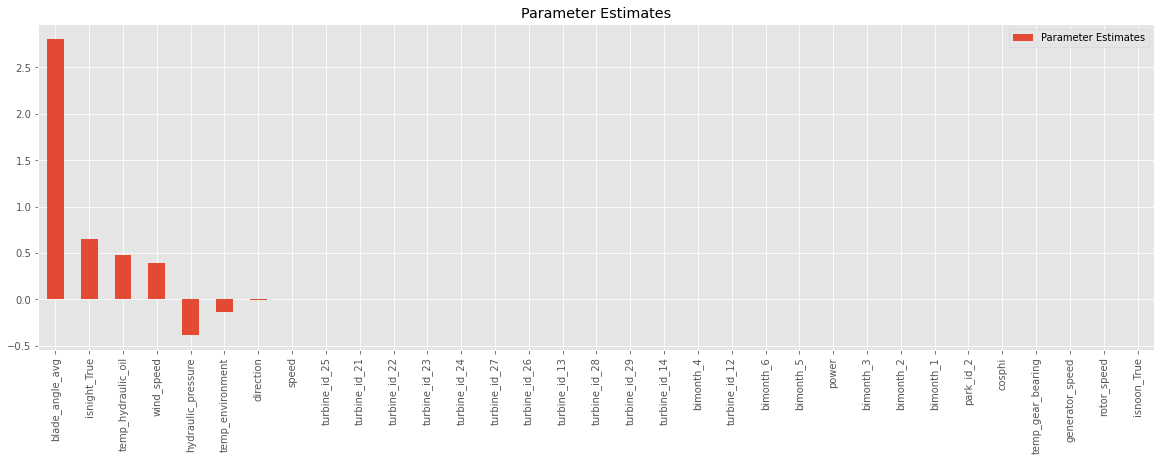

In [44]:
coefs=pd.DataFrame(lin_reg.coef_, index=X_test[num_attribs+encoded_cols].columns,columns=["Parameter Estimates"])
coefs.sort_values(by="Parameter Estimates",key=abs,ascending=False).plot(kind="bar",figsize=(20,6));
plt.title("Parameter Estimates");

We see that "blade_angle_avg" seems to be the most important attribute, followed by the "isnight" attribute which tests whether the data entry is taken during night or day.

In order to compare with the baseline error which one would obtain by prediciting that all data entries have no errors, we need to compute the baseline error first.

In [45]:
#Baseline accuracy by always guessing no error:
print("The Baseline error is:",round(np.sum(y_test)/len(y_test)*100,2), "%")

The Baseline error is: 7.2 %


We compute the accuracy of our predictions:

In [46]:
y_hat_test=(lin_reg.predict(X_test[num_attribs+encoded_cols])>=0.5)
from sklearn.metrics import accuracy_score
print("Accuracy is", round(accuracy_score(y_hat_test,y_test)*100,2), "%", )

Accuracy is 98.81 %


We compute the F1 scores both of the baseline, as well as of the GLM Lasso obtained with glum:

In [47]:
y_baseline=np.zeros(len(y_test))

from sklearn.metrics import f1_score

print("F1 score of baseline is", f1_score(y_test,y_baseline))
print("F1 score of glm lasso is", f1_score(y_test,y_hat_test))

F1 score of baseline is 0.0
F1 score of glm lasso is 0.9114614851408892


Now we use XGBoost instead.

Include the weeks as the attributes as well:

In [48]:
df_train.columns

Index(['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'error_category',
       'Error', 'month', 'bimonth', 'bimonthpark', 'speed', 'direction',
       'hourofday', 'isnight', 'isnoon', 'week'],
      dtype='object')

In [49]:
xgb_attribs=['turbine_id', 'wind_speed', 'power',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'month', 'speed', 'direction', 'hourofday',
        "isnoon","isnight","week"]

X_train_xgb=df_train[xgb_attribs]
X_test_xgb=df_test[xgb_attribs]

We run XGBoost with GridSearch over some parameters:

In [50]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb=XGBClassifier(eval_metric="logloss",use_label_encoder=False)
#parameters={"n_estimators":[100], "learning_rate":[0.1], "max_depth":[6]}
parameters2={"n_estimators":[100,125], "learning_rate":[0.1], "max_depth":[6],"gamma":[0,0.01,0.1]}

xgb_cv=GridSearchCV(xgb, parameters2, scoring="accuracy",cv=5)
xgb_cv.fit(X_train_xgb,y_train)

print("Best parameters:", xgb_cv.best_params_ , ", Best CV Accuracy:", xgb_cv.best_score_)

Best parameters: {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100} , Best CV Accuracy: 0.7842425559969619


In [51]:
y_hat_xgb=xgb_cv.best_estimator_.predict(X_test_xgb)
print("XGBC has test accuracy", round(100*(accuracy_score(y_hat_xgb,y_test)),2), "%")

XGBC has test accuracy 99.44 %


We plot the importance of the different features: 

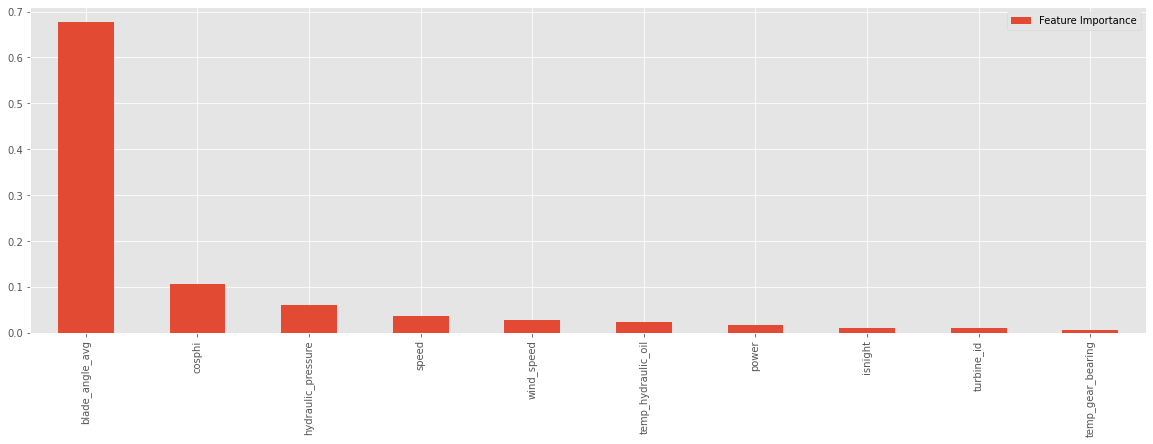

In [52]:
importance_df=pd.DataFrame(xgb_cv.best_estimator_.feature_importances_,index=X_train_xgb.columns, columns=["Feature Importance"])
importance_df.sort_values(by="Feature Importance", ascending=False).head(10).plot(kind="bar",figsize=(20,6));

In [53]:
print("F1 score of baseline is", f1_score(y_test,y_baseline))
print("F1 score of XGBC is", f1_score(y_test,y_hat_xgb))

F1 score of baseline is 0.0
F1 score of XGBC is 0.9614514802631579
